In [98]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Poisson
import statsmodels.api as sm
import pytest

In [99]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
names = []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
        names.append(file.split('.')[0].split('q')[1])
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCarlaScenes.json
Added  reqCARLAWildLifeCWL.json
Added  reqCARRADA.json
Added  reqCars.json
Added  reqCCSAD.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.js

In [100]:
print(len(names))
df_name = pd.DataFrame(names)
df_name.to_csv(f'output/retrieved_{len(names)}.csv', index=False, header=False, sep=",")

185


In [194]:
class scoring:
    def __init__(self, o_paper, lower_bound, upper_bound, impact_year):
        self.o_paper = o_paper
        self.lower_bound = o_paper['paperInfo']['year'] - lower_bound
        self.upper_bound = o_paper['paperInfo']['year'] + upper_bound
        self.impact_year = impact_year

    def number_citations_authors(self, author):
        """Returns a list where each entry is the number of citations a paper by a given author had up until the given year. Ignores citations without year resulting in different counts compared to the one given by the API."""
        ls_citations = []
        for paper in self.o_paper['paperInfo']['authors'][author]['authorsPapers']:
            #print(paper)
            if 'year' in paper and paper['year'] is not None and paper['year'] <= self.upper_bound:
                numb_cit = 0
                for citation in paper['citations']:
                    if 'year' in citation and citation['year'] is not None and self.upper_bound >= citation[
                        'year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def number_citations_ref(self, dimension='references', dimension_papers='citations'):
        """Like number_citations but the list elements represent the citations the references of a paper received."""
        ls_citations = []
        for paper in self.o_paper['paperInfo'][dimension]:
            if paper['year'] is not None and paper['year'] <= self.upper_bound and 'citations' in paper.keys():
                numb_cit = 0
                for citation in paper[dimension_papers]: #TODO: maybe change dimension_paper and paper?
                    if citation['year'] is not None and self.upper_bound >= citation['year'] >= self.lower_bound:
                        numb_cit += 1
                else:
                    ls_citations.append(numb_cit)
        return ls_citations

    def just_citations(self):
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            if paper['year'] is not None and self.o_paper['paperInfo']['year'] + self.impact_year >= paper[
                'year'] >= self.lower_bound:
                        numb_cit += 1
        return numb_cit

    def citations_h3(self):
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            #print(paper)
            if paper['year'] is not None and self.o_paper['paperInfo']['year'] + self.upper_bound >= paper[
                'year'] >= self.lower_bound:
                        numb_cit += 1
        return numb_cit

    def just_citations_non_cumulative(self):
        numb_cit = 0
        for paper in self.o_paper['paperInfo']['citations']:
            #print(paper)
            if paper['year'] is not None and self.o_paper['paperInfo']['year'] + self.impact_year == paper[
                'year']:
                        numb_cit += 1
                        #print((paper['year'] + self.impact_year))
        return numb_cit
    def reference_score(self):
        return calc_h_score(self.number_citations_ref())
    def citations_citations_score(self):
        return calc_h_score(self.number_citations_ref('citations', 'citations'))
    def citations_citations_sum(self):
        return np.sum(self.number_citations_ref('citations', 'citations'))
    def citations_single_author_score(self, author_number):
        return calc_h_score(self.number_citations_authors(author_number))


In [102]:
impact_year = 9
ind_paper = 0
print(retrieved_data[ind_paper]['id'])
scorer = scoring(retrieved_data[ind_paper], 200, 0, impact_year)
print(impact_year, retrieved_data[ind_paper]['paperInfo']['year']+impact_year, scorer.just_citations_non_cumulative())

KITTI
9 2022 987


In [103]:
retrieved_data[0]['paperInfo']['references'][0]

{'citations': [{'paperId': 'edb454208a16742615b0dd9c23a31d7bcde1dd3b',
   'year': 2022},
  {'paperId': '272fe83f6b9a80716952b20cb1d7cfd2f480a2c8', 'year': 2022},
  {'paperId': '0314cfdc5fac4f9a9b9195c73dea9e4a1203b471', 'year': 2021},
  {'paperId': 'ba426fe6e6af3d855cb5461725a7830dd8661ebf', 'year': 2022},
  {'paperId': '5df0f6b6372dfff270cac89bf7d0f461d69a2a4f', 'year': 2021},
  {'paperId': '51f349b27791484d41255944ad94e11690e2c710', 'year': 2020},
  {'paperId': '30863583187e6eb27efdbec50062bd53cf2f4fe6', 'year': 2020},
  {'paperId': '6990c3daf2da844ebdb2dea5877dedd45e5d5105', 'year': 2019},
  {'paperId': '3a7058616fdee4cb47de2f7c2ab9990660963d39', 'year': 2019},
  {'paperId': '9c5f7f314010ec8ba092e9d00444040dce021e96', 'year': 2019},
  {'paperId': '542de16b6f21c7089007a63a7504aec4a098a1f0', 'year': 2019},
  {'paperId': '37d446fe0421497544d67f9dc3c13abb3f16d2d4', 'year': 2018},
  {'paperId': '9b4001c8dbe3ed5b492ef1040d8fe622c523be97', 'year': 2018},
  {'paperId': '3887f78efaa5e751442f

In [104]:
retrieved_data[6]['paperInfo']['citations'][4]

{'paperId': '51324dc73ecfc8eb1f86013a81fab2ccf3ca3c57', 'year': 2022}

In [105]:
# 6 - camvid has some problem returns nones
for paper in retrieved_data:
    print(paper['id'], paper['citationCount'])

KITTI 5330
Cars 1939
nuImages 1805
nuScenes 1805
Synthia 1544
GTA5 1302
Caltech Pedestrian 1264
CamVid 993
Oxford Robot Car 950
Waymo Open Perception 888
GTSRB 758
Mapillary Vistas 754
Caltech Lanes 731
BDD100k 682
Beyond PASCAL 661
Argoverse 3D Tracking 593
Argoverse Motion Forecasting 593
GTSDB 588
LISA Traffic Sign 544
TT100K 441
CULane 430
TUD Brussels 416
ApolloScape 285
Road Damage 278
VPGNet 278
DDAD 265
NoCrash 218
Malaga Stereo and Laser Urban 211
INTERACTION 195
Brain4Cars 194
comma.ai 189
Oxford Radar Robot Car 173
Stanford Track Collection 171
India Driving 169
LISA Traffic Light 164
Bosch Small Traffic Lights Dataset 155
Bosch TL 155
DR(eye)VE 147
KITTI-360 141
JAAD 137
Nighttime Driving 137
TME Motorway 134
KAIST Multi-Spectral Day/Night 133
Lyft Level5 Perception 125
Lyft Level5 Prediction 125
One Thousand and One Hours 125
H3D 121
WoodScape 119
A2D2 117
Complex Urban 114
Synscapes 107
Waymo Open Motion 107
WildDash 104
UAH-DriveSet 97
BoxCars116k 96
Ground Truth Stixel 

In [106]:
retrieved_data[6]['publishDate']

'2010-03-01'

When do citations take off

In [107]:
# TODO: nuSecenes 60 citations stimmt nicht
def citation_timeline_array(retrieved_data):
    """Columns are years, rows datasets. column 0 is year prior to publication. column 1 year of pub. etc. entries are #citations that year"""
    array = np.zeros([len(retrieved_data), 16])
    names = []
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        names.append(paper['id'])
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            for impact_year in range(-1, 2022-retrieved_data[paper_idx]['paperInfo']['year']+1, 1):
                # iterates from 1 year prior to publication until today. e.g. kitti pub in 2012 2011-2022 -> last entry column 9
                scorer = scoring(paper, 200, 0, impact_year)
                print(impact_year, scorer.just_citations())
                array[paper_idx][array_idx] = scorer.just_citations()
                array_idx += 1
    return array, names
array, name = citation_timeline_array(retrieved_data)
array

 81%|████████  | 150/185 [00:00<00:00, 1487.36it/s]

-1 1
0 7
1 90
2 259
3 503
4 869
5 1454
6 2322
7 3355
8 4339
9 5326
-1 0
0 1
1 10
2 34
3 86
4 199
5 363
6 641
7 1035
8 1467
9 1946
-1 5
0 97
1 479
2 1056
3 1817
-1 5
0 97
1 479
2 1056
3 1817
-1 0
0 31
1 142
2 356
3 623
4 945
5 1269
6 1541
-1 0
0 23
1 125
2 304
3 521
4 773
5 1057
6 1301
-1 0
0 11
1 77
2 172
3 249
4 324
5 404
6 495
7 574
8 689
9 809
10 930
11 1059
12 1169
13 1263
-1 1
0 6
1 17
2 32
3 48
4 64
5 83
6 106
7 149
8 238
9 377
10 524
11 708
12 862
13 992
-1 8
0 56
1 169
2 330
3 558
4 760
5 949
-1 1
0 9
1 162
2 465
3 895
-1 1
0 14
1 34
2 50
3 77
4 111
5 148
6 217
7 325
8 443
9 571
10 667
11 759
-1 0
0 4
1 70
2 229
3 389
4 565
5 757
-1 0
0 1
1 5
2 17
3 36
4 64
5 105
6 151
7 208
8 275
9 356
10 455
11 532
12 629
13 684
14 733
-1 1
0 13
1 74
2 145
3 391
4 687
-1 0
0 11
1 58
2 111
3 182
4 303
5 410
6 508
7 598
8 659
-1 3
0 37
1 183
2 372
3 594
-1 3
0 37
1 183
2 372
3 594
-1 0
0 12
1 34
2 63
3 102
4 164
5 234
6 326
7 413
8 503
9 589
-1 0
0 5
1 23
2 58
3 121
4 165
5 233
6 295
7 380
8 45

100%|██████████| 185/185 [00:00<00:00, 1723.02it/s]

-1 0
0 0
1 13
2 41
3 59
4 74
-1 0
0 4
1 42
2 154
3 269
4 403
-1 0
0 2
1 6
2 9
3 13
-1 0
0 0
1 5
2 20
-1 0
0 0
1 25
2 64
3 131
-1 0
0 0
1 3
-1 0
0 0
-1 0
0 1
-1 0
0 0
1 0
-1 2
0 4
1 14
-1 0
0 7
1 32
-1 0
0 2
1 30
-1 0
0 17
1 45
2 90
-1 0
0 13
1 46
2 85
3 150
4 210
-1 0
0 10
1 25
2 58
3 100
4 143
5 202
6 258
-1 0
0 5
-1 0
0 0
1 28
2 70
3 96
-1 0
0 0
1 0
-1 0
0 0
-1 0
0 3
-1 0
0 0
1 2
2 24
3 47
-1 0
0 0
-1 0
0 2
1 7
2 46
3 105
-1 0
0 2
1 29
2 58
-1 0
0 1
1 3
2 8
-1 0
0 0
1 7
-1 0
0 1
1 29
2 81
3 186
4 322
5 421
6 519
-1 0
0 0
-1 0
0 5
1 12
2 31
3 66
-1 0
0 0
1 5
2 9
3 14
4 16
-1 1
0 20
1 33
2 53
-1 0
0 1
1 5
2 8
-1 0
0 3
1 9
2 22
3 35
-1 0
0 0
1 1
-1 0
0 0


array([[  1.,   7.,  90., ...,   0.,   0.,   0.],
       [  0.,   1.,  10., ...,   0.,   0.,   0.],
       [  5.,  97., 479., ...,   0.,   0.,   0.],
       ...,
       [  0.,   3.,   9., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [108]:
data = array
data = np.delete(data, np.s_[-12:], axis=1)
df = pd.DataFrame(data).set_axis(name)#
for column in range(df.shape[1]):
    if column >= 3:
        df = df[df[column] > 0]
data = np.array(df)

In [109]:
data

array([[1.000e+00, 7.000e+00, 9.000e+01, 2.590e+02],
       [0.000e+00, 1.000e+00, 1.000e+01, 3.400e+01],
       [5.000e+00, 9.700e+01, 4.790e+02, 1.056e+03],
       [5.000e+00, 9.700e+01, 4.790e+02, 1.056e+03],
       [0.000e+00, 3.100e+01, 1.420e+02, 3.560e+02],
       [0.000e+00, 2.300e+01, 1.250e+02, 3.040e+02],
       [0.000e+00, 1.100e+01, 7.700e+01, 1.720e+02],
       [1.000e+00, 6.000e+00, 1.700e+01, 3.200e+01],
       [8.000e+00, 5.600e+01, 1.690e+02, 3.300e+02],
       [1.000e+00, 9.000e+00, 1.620e+02, 4.650e+02],
       [1.000e+00, 1.400e+01, 3.400e+01, 5.000e+01],
       [0.000e+00, 4.000e+00, 7.000e+01, 2.290e+02],
       [0.000e+00, 1.000e+00, 5.000e+00, 1.700e+01],
       [1.000e+00, 1.300e+01, 7.400e+01, 1.450e+02],
       [0.000e+00, 1.100e+01, 5.800e+01, 1.110e+02],
       [3.000e+00, 3.700e+01, 1.830e+02, 3.720e+02],
       [3.000e+00, 3.700e+01, 1.830e+02, 3.720e+02],
       [0.000e+00, 1.200e+01, 3.400e+01, 6.300e+01],
       [0.000e+00, 5.000e+00, 2.300e+01, 5.800

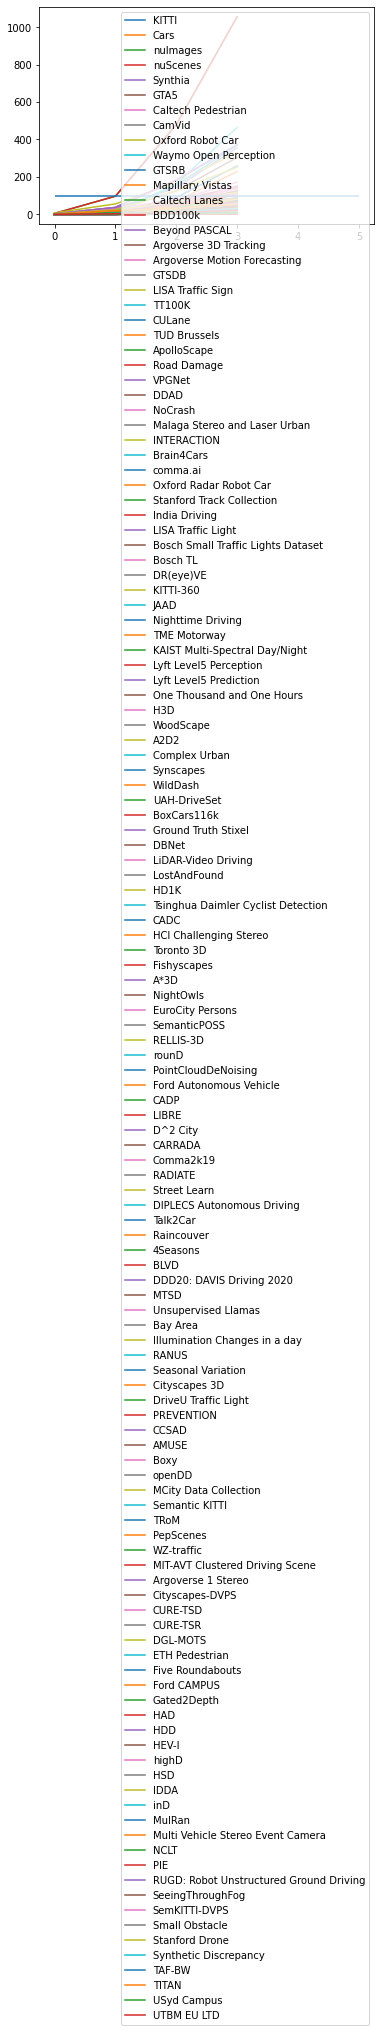

In [110]:
df_transpose = df.transpose()
df_transpose.plot()
plt.hlines(100, 0, 5)

In [111]:
df_transpose

,KITTI,Cars,nuImages,nuScenes,Synthia,GTA5,Caltech Pedestrian,CamVid,Oxford Robot Car,Waymo Open Perception,...,RUGD: Robot Unstructured Ground Driving,SeeingThroughFog,SemKITTI-DVPS,Small Obstacle,Stanford Drone,Synthetic Discrepancy,TAF-BW,TITAN,USyd Campus,UTBM EU LTD
0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,1.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.0,1.0,97.0,97.0,31.0,23.0,11.0,6.0,56.0,9.0,...,0.0,2.0,2.0,1.0,1.0,5.0,0.0,20.0,1.0,3.0
2,90.0,10.0,479.0,479.0,142.0,125.0,77.0,17.0,169.0,162.0,...,2.0,7.0,29.0,3.0,29.0,12.0,5.0,33.0,5.0,9.0
3,259.0,34.0,1056.0,1056.0,356.0,304.0,172.0,32.0,330.0,465.0,...,24.0,46.0,58.0,8.0,81.0,31.0,9.0,53.0,8.0,22.0


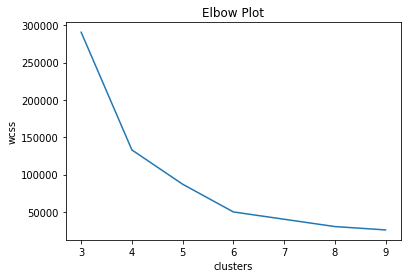

In [112]:
wcss = []
for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
plt.plot([*range(3, 10)], wcss)
plt.title('Elbow Plot')
plt.xlabel('clusters')
plt.ylabel('wcss')
plt.show()
#choose last bend

97
10
2
25


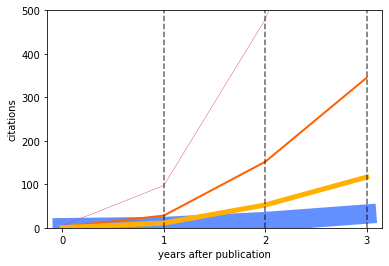

In [113]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(data)
clusters = kmeans.cluster_centers_
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE'] #
labels = pd.Series(kmeans.labels_)
labels = labels.value_counts(ascending=True).sort_index()
for label, cluster in enumerate(clusters):
    plt.plot([*range(0, cluster.shape[0])], cluster, alpha=1, label=label, color=colors[label] ,lw=labels.iloc[label]/5)
    print(labels.iloc[label])
y_lim = 500
plt.ylim(0, y_lim)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(3, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(0, cluster.shape[0])])
plt.ylabel('citations')
plt.xlabel('years after publication')
#plt.title('Centers of Clusters from k-Means')
plt.savefig('output/citations_clustering.pdf', bbox_inches='tight')
#plt.legend()
#plt.hlines(50, 0, 5, linestyles='dashed', color='black')
plt.show()


In [114]:
#np.lexsort((kmeans.cluster_centers_[:,-1]))

In [115]:
labels = pd.Series(kmeans.labels_)
labels.value_counts(ascending=True)

2     2
1    10
3    25
0    97
dtype: int64

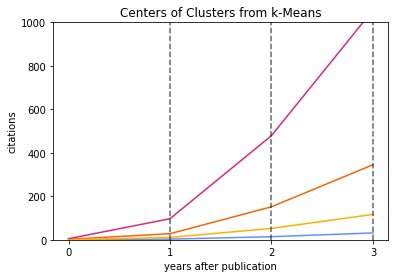

In [116]:
colors = ['#648fff', '#fe6100', '#dc267f', '#ffb000', '#785ef0', '#A740AE']
for idx, cluster in enumerate(clusters):
    plt.plot([*range(0, cluster.shape[0])], cluster, alpha=1, color=colors[idx])
y_lim = 1000
plt.ylim(0, y_lim)
plt.vlines(1, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(2, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.vlines(3, 0, y_lim, colors='black', linestyles='dashed', alpha=0.6)
plt.xticks([*range(0, cluster.shape[0])])
plt.ylabel('citations')
plt.xlabel('years after publication')
plt.title('Centers of Clusters from k-Means')
plt.savefig('output/citations_clustering_1000.svg')
#plt.hlines(50, 0, 5, linestyles='dashed', color='black')
plt.show()

In [117]:
def calc_h_score(citations):
    if citations:
        citations = np.array(citations)
        n         = citations.shape[0]
        array     = np.arange(1, n+1)
        # reverse sorting
        citations = np.sort(citations)[::-1]
        # intersection of citations and k
        h_idx = np.max(np.minimum(citations, array))
        return h_idx
    else:
        return 0

In [118]:
'''def expected_impact_score(o_paper, upper_bound, alpha=1, beta=1, gamma=1, theta=1): #Todo sum of weights = 1
    lower_bound = 5
    scorer = scoring(o_paper, lower_bound, upper_bound, 3)
    citation_c = scorer.just_citations(o_paper)
    reference_score_c = scorer.reference_score(o_paper)
    citations_citations_c = scorer.citations_citations_score(o_paper)
    ls_author_scores = []
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(o_paper, author_number)
        ls_author_scores.append(single_author_score)
    mean_author_score = np.mean(ls_author_scores)
    #print('Median author score', mean_author_score)
    return round(alpha*reference_score_c + beta*citations_citations_c + gamma*citation_c + theta*mean_author_score, 1)'''

"def expected_impact_score(o_paper, upper_bound, alpha=1, beta=1, gamma=1, theta=1): #Todo sum of weights = 1\n    lower_bound = 5\n    scorer = scoring(o_paper, lower_bound, upper_bound, 3)\n    citation_c = scorer.just_citations(o_paper)\n    reference_score_c = scorer.reference_score(o_paper)\n    citations_citations_c = scorer.citations_citations_score(o_paper)\n    ls_author_scores = []\n    for author_number, author in enumerate(o_paper['paperInfo']['authors']):\n        single_author_score = scorer.citations_single_author_score(o_paper, author_number)\n        ls_author_scores.append(single_author_score)\n    mean_author_score = np.mean(ls_author_scores)\n    #print('Median author score', mean_author_score)\n    return round(alpha*reference_score_c + beta*citations_citations_c + gamma*citation_c + theta*mean_author_score, 1)"

In [119]:
def create_modelling_df(retrieved_data, lower_bound, upper_bound, impact_year):
    array = np.zeros([len(retrieved_data), 5])

    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.just_citations()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = round(np.mean(ls_author_scores[1:], 0))
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:5] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score, first_author_score]
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    similar_age_3m = []
    row_w_missing_data = []
    missing_altmetirc_counter = 0
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            similar_age_3m_value = paper['altmetrics'][2]['similar_age_3m_percentile']['percentile']
        except:
            row_w_missing_data.append(idx_paper)
            missing_altmetirc_counter += 1
            print('Missing_Altmetric', missing_altmetirc_counter)
            continue
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
        sensors.append(sensors_value)
        similar_age_3m.append(similar_age_3m_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print("Missing Data:", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    df['similar_age_3m_percentile'] = similar_age_3m
    cols = list(df.columns)
    cols[:5] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score', 'first_author_score']
    df.columns = cols


    #print(row_w_missing_data)
    print(df.shape)
    df = df[df.year <= 2020] #2019
    print(df.shape)
    print('Warning. This function still has altmetrics')
    return df

In [207]:
def create_modelling_df_no_altmetrics(retrieved_data, lower_bound, upper_bound, impact_year):
    array = np.zeros([len(retrieved_data), 5])
    for paper_idx, paper in enumerate(tqdm(retrieved_data)):
        if 'paperInfo' in retrieved_data[paper_idx].keys() and 'year' in retrieved_data[paper_idx]['paperInfo'].keys():
            array_idx = 0
            o_paper = retrieved_data[paper_idx]
            scorer = scoring(o_paper, lower_bound, upper_bound, impact_year)
            citation_c = scorer.citations_h3()
            citations_citations_c = scorer.citations_citations_score()
            reference_score_c = scorer.reference_score()
            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            first_author_score = round(ls_author_scores[0], 0)
            if len(ls_author_scores)>1:
                #print(len(ls_author_scores), ls_author_scores)
                mean_author_score = round(np.mean(ls_author_scores[1:], 0))
            elif len(ls_author_scores)==2:
                mean_author_score = ls_author_scores[1]
            else:
                mean_author_score = 0
            array[paper_idx][:5] = [citation_c, citations_citations_c, reference_score_c,  mean_author_score, first_author_score]
            array_idx += 1
    names = []
    year = []
    sensors = []
    frames = []
    row_w_missing_data = []
    for idx_paper, paper in enumerate(retrieved_data):
        names.append(paper['id'])
        year.append(paper['paperInfo']['year'])
        try:
            sensors_value = int(len(list(paper['sensors'].split(','))))
            if paper['frames'] != "-":
                frames_value = (paper['frames'])
            else:
                row_w_missing_data.append(idx_paper)
                continue
        except:
            row_w_missing_data.append(idx_paper)
            continue
        frames.append(frames_value)
        sensors.append(sensors_value)
    df = pd.DataFrame(array).set_axis(names)
    df['year'] = year
    df = df.drop(df.index[row_w_missing_data])
    print("Missing Data:", len(row_w_missing_data))
    df['sensors'] = sensors
    df['frames'] = frames
    cols = list(df.columns)
    cols[:5] = ['citation_c', 'citations_citations_c', 'reference_score_c', 'mean_author_score', 'first_author_score']
    df.columns = cols
    #print(row_w_missing_data)
    print(df.shape)
    df = df[df.year <= (2022-impact_year)]
    print(df.shape)
    return df

In [208]:
def convert_data(df, drop='citations_citations_c', dependent_var='citation_c'):
    replacement = df.at['Street Learn', 'frames'].replace(',', '')
    #print(replacement)
    df.at['Street Learn', 'frames'] = replacement
    modelling_df = df
    # modelling_df = modelling_df.drop(['BDD100k', 'Argoverse Motion Forecasting'], axis=0)
    modelling_df = modelling_df.drop([drop], axis=1)
    for idx_column, col in enumerate(modelling_df.columns):
        modelling_df[col] = modelling_df[col].astype("float")
    for idx, variable in enumerate(modelling_df):
        plt.scatter(modelling_df[variable], modelling_df[dependent_var])
        plt.xlabel(list(modelling_df.columns)[idx])
        plt.show()
        plt.hist(modelling_df[variable])
        plt.show()
    print(modelling_df.frames.max())
    modelling_df[dependent_var] = np.log(modelling_df[dependent_var]+1)
    modelling_df.frames = np.log(modelling_df.frames)
    return modelling_df

def normalize(modelling_df, dependent_var='citation_c'):
    #modelling_df['similar_age_3m_percentile'] = np.log(modelling_df.similar_age_3m_percentile+1)
    for idx_column, col in enumerate(modelling_df.columns):
        if col != dependent_var:
                modelling_df[col] = (modelling_df[col]-modelling_df[col].mean())/(modelling_df[col].std())
                plt.scatter(modelling_df[col], modelling_df[dependent_var])
                plt.xlabel(list(modelling_df.columns)[idx_column])
                plt.show()

    #modelling_df['reference_score_2'] = np.square(modelling_df.reference_score_c)
    #modelling_df['first_author_score2'] = np.square(modelling_df.first_author_score)
    #modelling_df['mean_author_score2'] = np.square(modelling_df.mean_author_score)
    return modelling_df

def mean_centering(modelling_df):
    #modelling_df['similar_age_3m_percentile'] = modelling_df['similar_age_3m_percentile']-modelling_df['similar_age_3m_percentile'].mean()
    modelling_df['mean_author_score'] = modelling_df['mean_author_score']-modelling_df['mean_author_score'].mean()
    modelling_df['similar_age_3m_percentile'] = np.square(modelling_df.similar_age_3m_percentile)
    modelling_df['mean_author_score2'] = np.square(modelling_df.mean_author_score)
    return modelling_df

def modelling(modelling_df, dependent_var='citation_c'):
    independent_vars = modelling_df.drop([dependent_var], axis=1)
    X = add_constant(independent_vars)
    y = modelling_df[dependent_var]
    mod = sm.regression.linear_model.OLS(y, independent_vars.assign(intercept=1))
    res = mod.fit(cov_type="HC1")
    print(res.summary())
    test = sm.stats.diagnostic.het_breuschpagan(res.resid, res.model.exog)
    print('test', test)
    vif = pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
    print(vif)
    fitted_y = res.fittedvalues
    plot = sns.residplot(x=fitted_y, y=modelling_df[dependent_var], data=modelling_df, lowess=True)
    plt.show()
    for variable in independent_vars:
        plot = sns.residplot(x=independent_vars[variable], y=modelling_df[dependent_var], data=modelling_df, lowess=True)
        plt.show()
    return res, fitted_y, y, independent_vars


wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        #print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)



In [209]:
'''df = create_modelling_df(retrieved_data, 3, 0, 3)
df'''


'df = create_modelling_df(retrieved_data, 3, 0, 3)\ndf'

In [210]:
#retrieved_data[0]['paperInfo']['authors'][0]['authorsPapers'][0]


In [211]:
#retrieved_data[0]['altmetrics']

In [212]:
#df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 3)
#df

100%|██████████| 185/185 [00:01<00:00, 107.07it/s]

Missing Data: 76
(109, 8)
(70, 8)


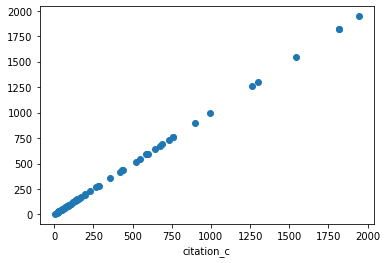

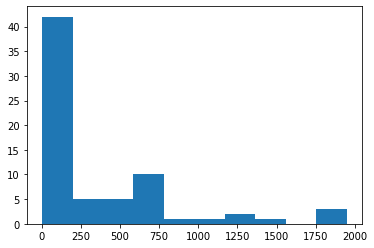

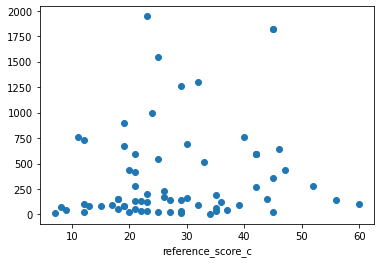

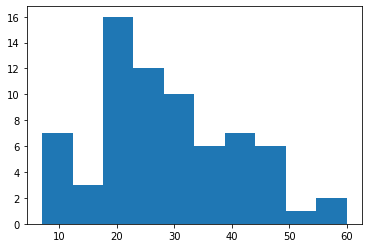

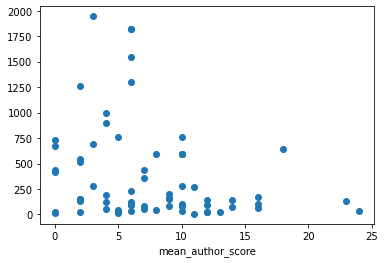

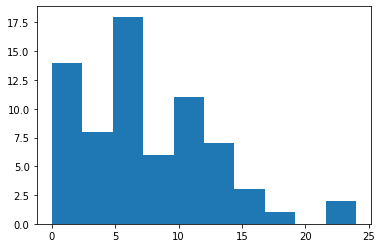

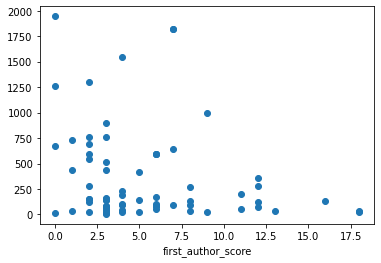

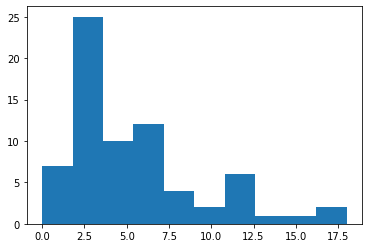

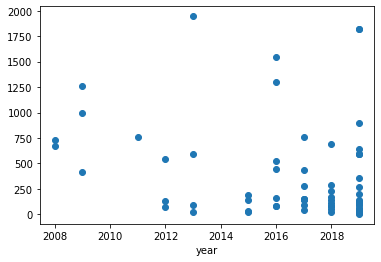

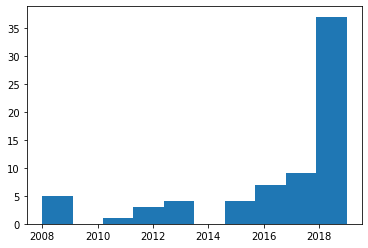

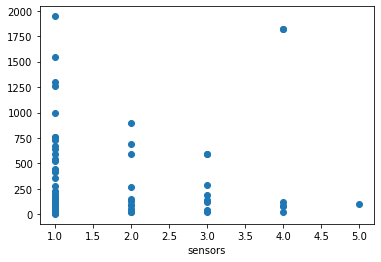

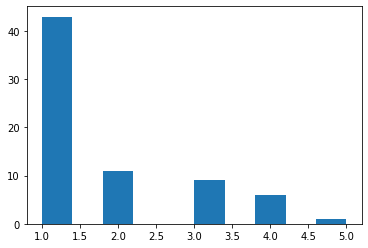

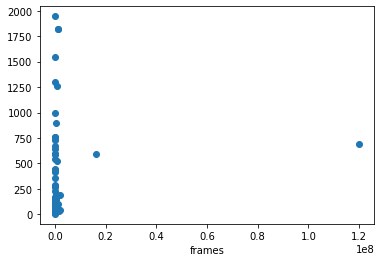

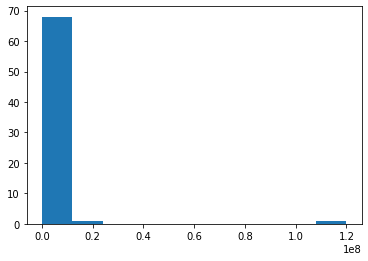

120000000.0


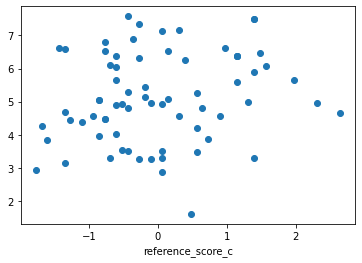

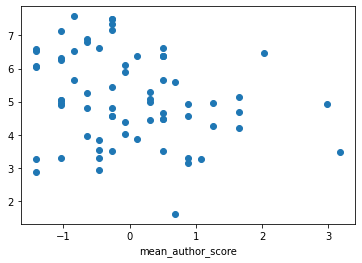

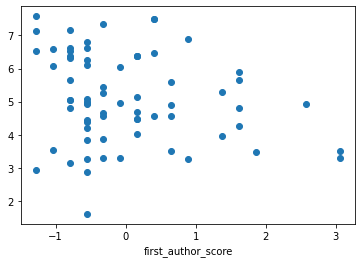

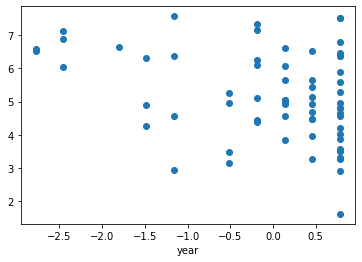

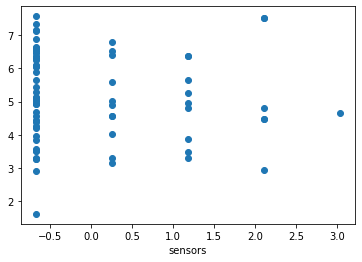

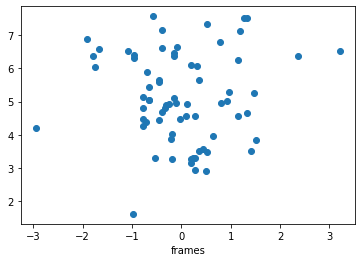

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     10.11
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           8.25e-08
Time:                        19:58:04   Log-Likelihood:                -107.58
No. Observations:                  70   AIC:                             229.2
Df Residuals:                      63   BIC:                             244.9
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
reference_score_c      0.6085      0

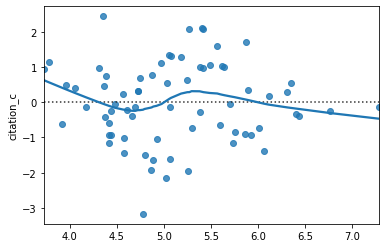

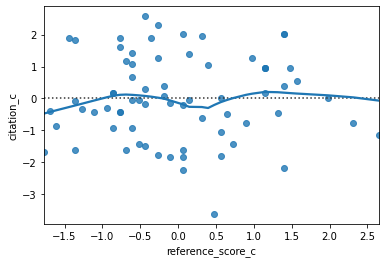

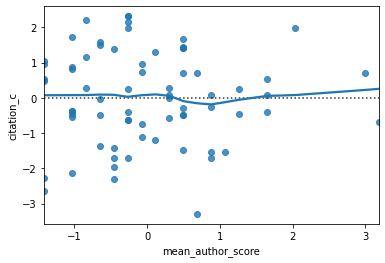

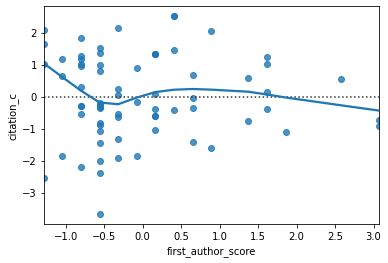

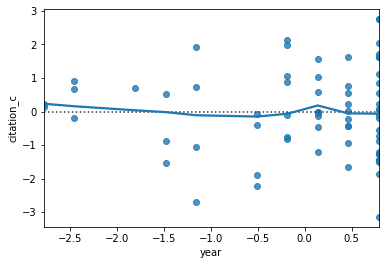

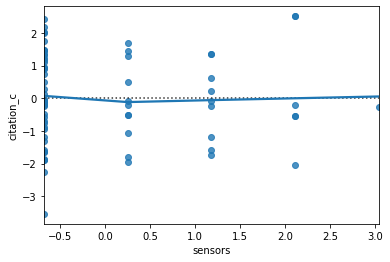

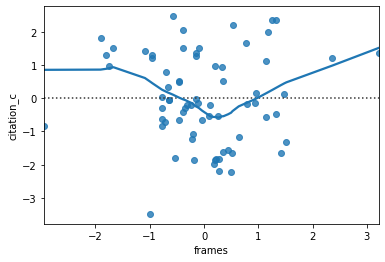

197668.41905928528


In [213]:
df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 3)
modelling_df = convert_data(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y_ols, x = modelling(modelling_df_normalized)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)
# df = create_modelling_df(retrieved_data, 3, 0, 3)
# modelling_df = convert_data(df)
# modelling_df.corr()

100%|██████████| 185/185 [00:01<00:00, 116.29it/s]

Missing Data: 76
(109, 8)
(79, 8)


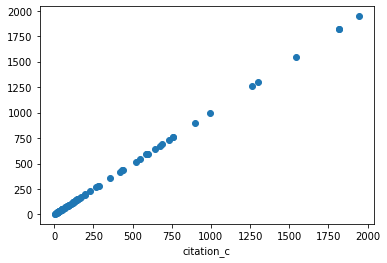

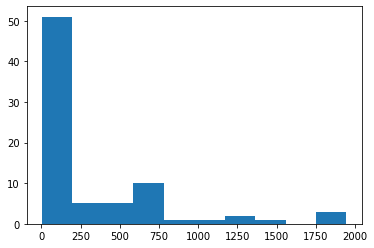

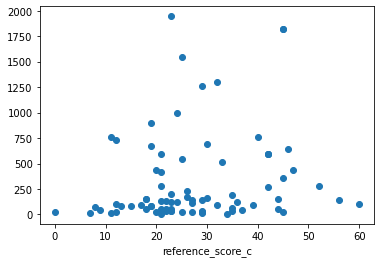

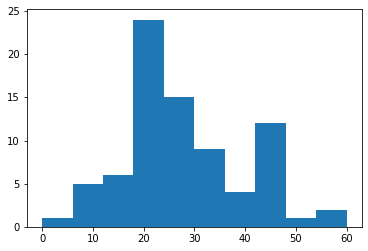

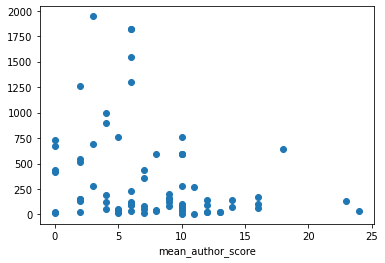

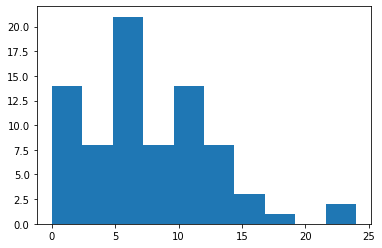

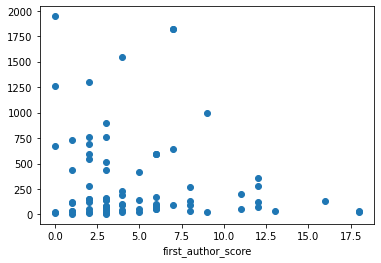

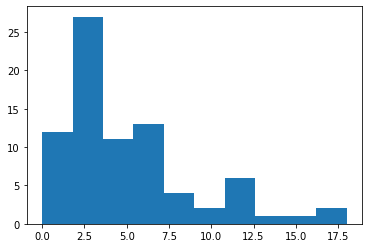

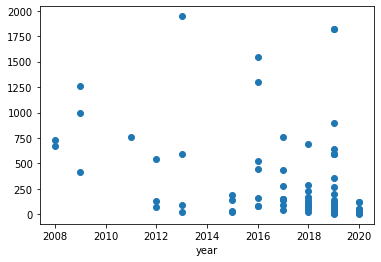

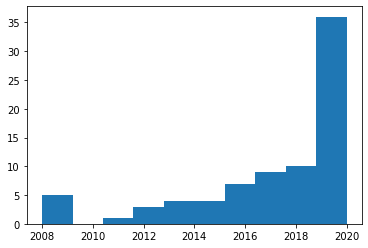

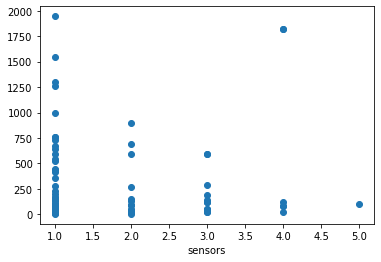

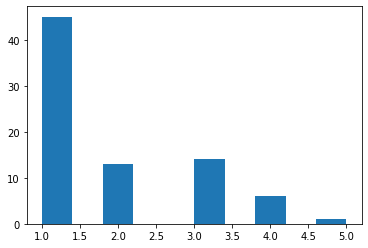

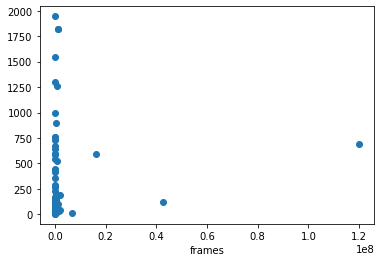

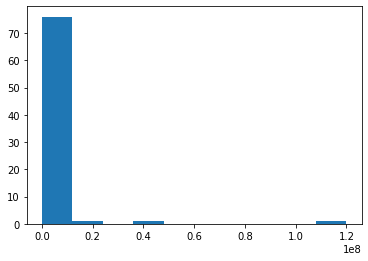

120000000.0


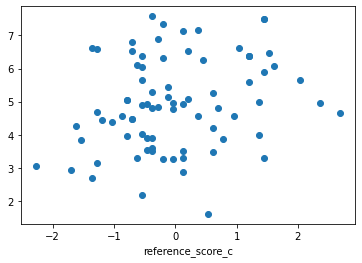

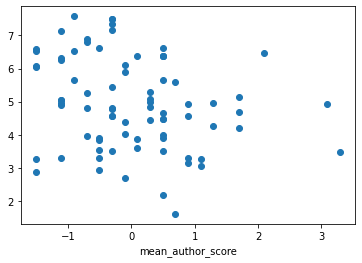

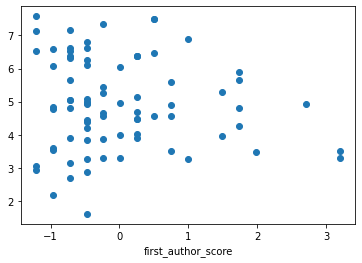

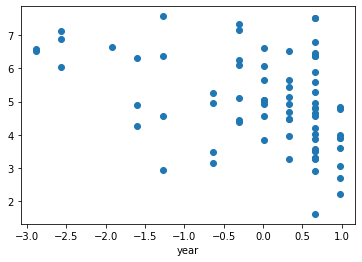

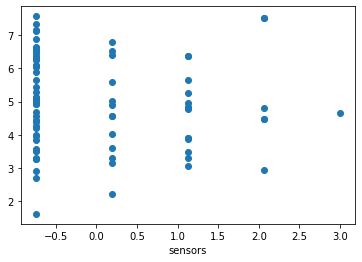

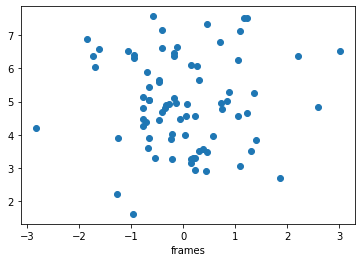

                            OLS Regression Results                            
Dep. Variable:             citation_c   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     15.97
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           1.40e-11
Time:                        19:58:09   Log-Likelihood:                -119.00
No. Observations:                  79   AIC:                             252.0
Df Residuals:                      72   BIC:                             268.6
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
reference_score_c      0.6316      0

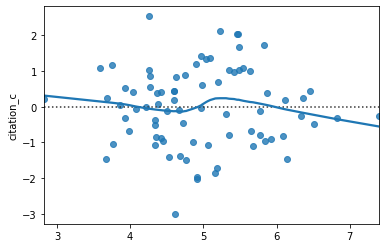

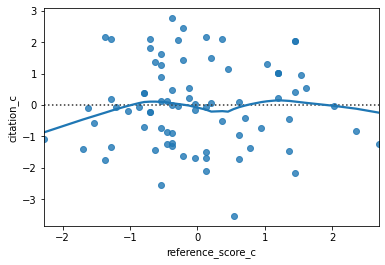

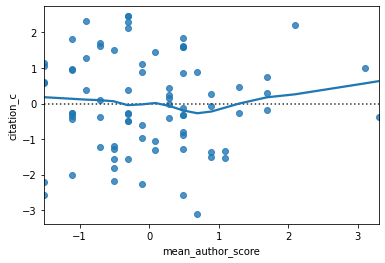

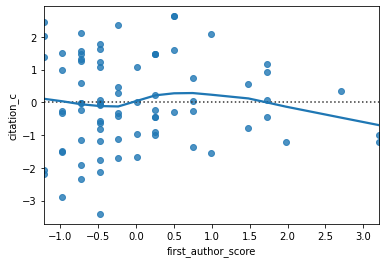

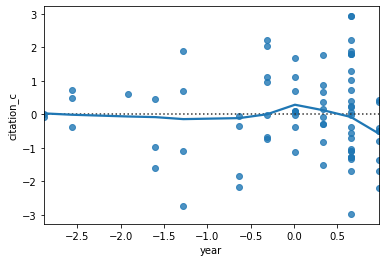

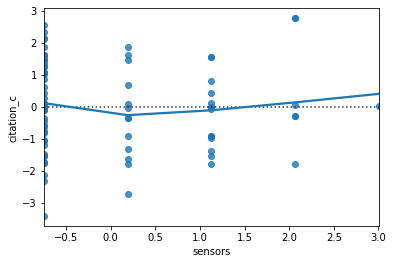

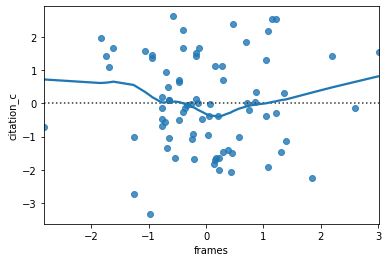

178133.7531746381


In [214]:
df = create_modelling_df_no_altmetrics(retrieved_data, 3, 0, 2)
modelling_df = convert_data(df)
modelling_df_normalized = normalize(modelling_df)
res, fitted_y, y_ols, x = modelling(modelling_df_normalized)
print(sm.tools.eval_measures.mse(np.exp(fitted_y)-1, np.exp(y_ols))-1)

Making Citation Predictor

In [128]:
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split


In [129]:
modelling_df

,citation_c,reference_score_c,mean_author_score,first_author_score,year,sensors,frames
Cars,3.555348,-0.372983,-0.911295,-1.214307,-1.276961,-0.747573,-0.576404
nuImages,6.963190,1.447930,-0.309688,0.503114,0.656839,2.064724,1.157877
nuScenes,6.963190,1.447930,-0.309688,0.503114,0.656839,2.064724,1.219963
Synthia,5.877736,-0.207446,-0.309688,-0.232923,-0.310061,-0.747573,0.462347
GTA5,5.720312,0.371936,-0.309688,-0.723615,-0.310061,-0.747573,-0.401836
...,...,...,...,...,...,...,...
SeeingThroughFog,3.850148,2.689461,0.492455,-0.232923,0.656839,3.002156,1.219963
Small Obstacle,2.197225,-0.538521,0.492455,-0.968961,0.979139,0.189860,-1.265167
Stanford Drone,4.406719,0.454704,-1.111831,-0.478269,-0.310061,-0.747573,1.055000
Synthetic Discrepancy,3.465736,0.620242,1.695669,-0.478269,0.656839,-0.747573,-2.830852


In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    modelling_df.drop(['citation_c'], axis=1), modelling_df['citation_c'], test_size=0.3, random_state=13
)
X_train, X_fin, y_train, y_fin = train_test_split(
    X_test, y_test, test_size=0.3, random_state=13
)

In [131]:
params = {
    "n_estimators": 10,
    "max_depth": 20,
    "min_samples_split": 3,
    "learning_rate": 0.8,
    "loss": "squared_error",
}

In [132]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.8, max_depth=20, min_samples_split=3,
                          n_estimators=10)

In [133]:
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
r2 = r2_score(y_test, reg.predict(X_test))
print("The R squared  (R2) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 0.8645
The R squared  (R2) on test set: 0.1441


The mean absolute error (MAE) on test set: 26.9703
The mean squared error (MSE) on test set: 4438.9821


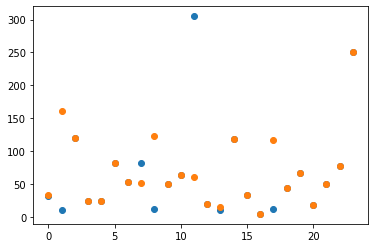

In [134]:

comparison = [np.exp(y_test), np.exp(reg.predict(X_test))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(y_test))], comparison[0])
plt.scatter([*range(len(y_test))], comparison[1])
plt.show()

The mean absolute error (MAE) on test set: 80.9108
The mean squared error (MSE) on test set: 13316.9463


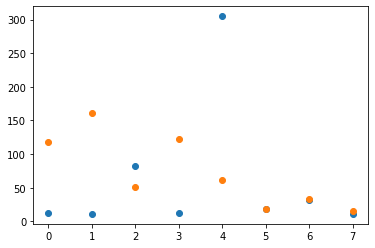

In [135]:
comparison = [np.exp(y_fin), np.exp(reg.predict(X_fin))]
mae = mean_absolute_error(comparison[0], comparison[1])
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
mse = mean_squared_error(comparison[0], comparison[1])
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
plt.scatter([*range(len(comparison[0]))], comparison[0])
plt.scatter([*range(len(comparison[0]))], comparison[1])
plt.show()

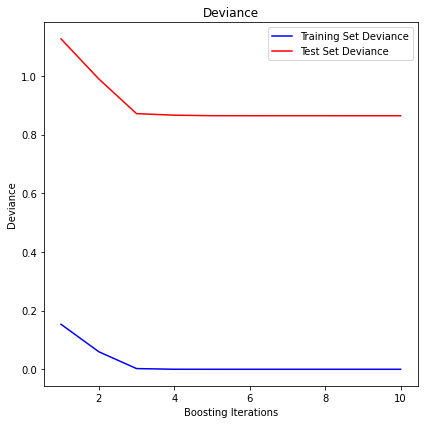

In [136]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [137]:
#todo: 5best - 5 worst by impact time development graph: no readers and altmetric because there is no historical data
#table for all new ones this year: 28. paper_name, IS, feature_1, ..., feature_n

In [138]:
wd = os.getcwd()
wd = wd.replace('.ipynb_checkpoints', '')
directory = os.path.join(wd, 'data', 'requests5')
retrieved_data =  []
for file in os.listdir(directory):
    with open(os.path.join(directory, file), "r") as j:
        a = json.loads(j.read())
        retrieved_data.append(a)
        print('Added ', file)
#retrieved_data
retrieved_data = sorted(retrieved_data, key=itemgetter('citationCount'), reverse=True)

Added  req4Seasons.json
Added  reqA2D2.json
Added  reqA3D.json
Added  reqA9.json
Added  reqaiMotive.json
Added  reqAmodalCityscapes.json
Added  reqAMUSE.json
Added  reqApolloScape.json
Added  reqArgoverse1Stereo.json
Added  reqArgoverse3DTracking.json
Added  reqArgoverseMotionForecasting.json
Added  reqAugKITTI.json
Added  reqAutomatumOpenHighway.json
Added  reqAutonomousPlatformInertial.json
Added  reqBayArea.json
Added  reqBDD100k.json
Added  reqBeyondPASCAL.json
Added  reqBLVD.json
Added  reqBoreas.json
Added  reqBoschSmallTrafficLightsDataset.json
Added  reqBoschTL.json
Added  reqBoxCars116k.json
Added  reqBoxy.json
Added  reqBrain4Cars.json
Added  reqCADC.json
Added  reqCADP.json
Added  reqCaltechLanes.json
Added  reqCaltechPedestrian.json
Added  reqCamVid.json
Added  reqCarlaScenes.json
Added  reqCARLAWildLifeCWL.json
Added  reqCARRADA.json
Added  reqCars.json
Added  reqCCSAD.json
Added  reqCityscapes3D.json
Added  reqCityscapesDVPS.json
Added  reqCODA.json
Added  reqComma2k19.js

In [139]:
for i in range(len(retrieved_data)):
    print(retrieved_data[i]['paperInfo']['year'])

2013
2013
2019
2019
2016
2016
2009
2009
2017
2019
2011
2017
2008
2018
2014
2019
2019
2013
2012
2016
2017
2009
2018
2018
2017
2019
2019
2014
2019
2015
2016
2019
2011
2018
2016
2017
2017
2017
2015
2017
2018
2012
2018
2020
2020
2020
2019
2019
2020
2019
2018
2021
2018
2016
2017
2013
2018
2018
2016
2022
2016
2016
2020
2022
2012
2020
2019
2019
2018
2019
2020
2021
2020
2020
2019
2020
2018
2020
2019
2020
2018
2020
2019
2015
2019
2017
2021
2021
2020
2019
2020
2019
2019
2014
2014
2018
2014
2020
2018
2019
2021
2015
2021
2021
2021
2013
2019
2021
2020
2019
2019
2021
2017
2021
2020
2022
2022
2021
2019
2021
2022
2021
2022
2021
2022
2020
2022
2022
2019
2022
2021
2022
2022
2022
2022
2020
2022
2019
2017
2019
2008
2022
2018
2011
2019
2021
2021
2019
2022
2018
2018
2018
2019
2020
2019
2021
2022
2022
2021
2021
2021
2021
2020
2018
2016
2022
2019
2021
2022
2022
2019
2022
2019
2020
2020
2021
2016
2022
2019
2018
2020
2020
2019
2021
2022


In [140]:
yr = 2022
array = np.empty([len(retrieved_data), 9])
array[:] = np.nan
names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    scorer = scoring(o_paper, 3, yr, yr)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()
    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        percentile = float("NaN")
        total_readers = float("NaN")
    try:
        sensors_value = int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_value = float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_value = int(o_paper['frames'].replace(',', ''))
        else:
            frames_value = float("NaN")
    except:
                frames_value = float("NaN")
    publication = o_paper['paperInfo']['year']


    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author, sensors_value, frames_value, publication]
array

100%|██████████| 185/185 [00:02<00:00, 91.09it/s] 


array([[5.3300e+03, 1.5100e+02, 2.0010e+03, ..., 3.0000e+00,        nan,
        2.0130e+03],
       [1.9460e+03, 1.0700e+02,        nan, ..., 1.0000e+00, 1.6185e+04,
        2.0130e+03],
       [1.8180e+03, 6.9000e+01,        nan, ..., 4.0000e+00, 1.2000e+06,
        2.0190e+03],
       ...,
       [3.5000e+01, 8.0000e+00,        nan, ..., 4.0000e+00,        nan,
        2.0190e+03],
       [1.0000e+00, 0.0000e+00,        nan, ..., 2.0000e+00, 7.6500e+04,
        2.0210e+03],
       [0.0000e+00, 0.0000e+00,        nan, ..., 1.0000e+00,        nan,
        2.0220e+03]])

In [141]:
df_features_IS = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author', 'sensors_abs', 'frames_abs', 'publicationYear']).set_axis(names).drop_duplicates()
df_features_IS['Altmetric'] = df_features_IS.score.rank(pct = True)
df_features_IS['cit'] = df_features_IS.citations.rank(pct = True)
df_features_IS['h-cit'] = df_features_IS.citations_citations.rank(pct = True)
df_features_IS['readers'] = df_features_IS.total_readers.rank(pct = True)
df_features_IS['refs'] = df_features_IS.reference.rank(pct = True)
df_features_IS['authors'] = df_features_IS.author.rank(pct = True)
df_features_IS['sensors'] = df_features_IS.sensors_abs.rank(pct = True)
df_features_IS['frames'] = df_features_IS.frames_abs.rank(pct = True)
df_features_IS = df_features_IS.iloc[:, -9:]
df_features_IS

,publicationYear,Altmetric,cit,h-cit,readers,refs,authors,sensors,frames
KITTI,2013.0,0.983333,1.000000,1.000000,1.000000,0.075000,0.972222,0.763006,NaN
Cars,2013.0,0.786111,0.994444,0.986111,NaN,0.669444,0.836111,0.242775,0.299065
nuImages,2019.0,0.786111,0.986111,0.938889,NaN,0.963889,0.202778,0.921965,0.878505
nuScenes,2019.0,0.786111,0.986111,0.944444,NaN,0.963889,0.202778,0.921965,0.901869
Synthia,2016.0,0.938889,0.977778,0.994444,NaN,0.683333,0.483333,0.242775,0.757009
...,...,...,...,...,...,...,...,...,...
TAF-BW,2018.0,0.305556,0.263889,0.308333,NaN,0.125000,0.216667,0.242775,NaN
TITAN,2020.0,0.305556,0.522222,0.500000,NaN,0.891667,0.402778,0.242775,0.560748
USyd Campus,2020.0,0.705556,0.211111,0.180556,0.038462,0.205556,0.502778,0.991329,NaN
UTBM EU LTD,2019.0,0.305556,0.450000,0.433333,NaN,0.322222,0.744444,0.921965,NaN


In [142]:
def influence_score(scores, weights=[1, 1, 1, 1, 1, 1, 1, 1], selected_features='default'): #Todo sum of weights = 1
    """Calculates Influence score of one paper based on given weights. IS=sum(weight_i*feature_i). Summ of weights is 1. Missing features are omitted and the remaining weights are rescaled so that their sum is equal to one. """
    weights = np.array(weights, dtype=float)
    #make array with all available features, i.e. exclude NaNs
    if selected_features == 'default': # no sensors
        selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
    if selected_features == 'all':
        selected_features = scores.index
        #print(selected_features)
    ls_available_features = []
    for index_feature, feature in enumerate(selected_features):
        if not np.isnan(scores[feature]):
            ls_available_features.append((index_feature, feature))
            #print(feature)

    #scale weights
    if len(ls_available_features) != len(weights):
        weights_to_scale = np.zeros(len(ls_available_features))
        for index_insert, feature in enumerate(ls_available_features):
            weights_to_scale[index_insert] = weights[feature[0]]
        weights = weights_to_scale

    weights /= np.sum(weights)
    assert np.sum(weights) == pytest.approx(1)
    #print('Scaled weights:', weights)
    #print('Available features', len(ls_available_features), ls_available_features)
    #calculate score
    result = 0
    for index, feature in enumerate(ls_available_features):
        #print(result)
        #print(feature)
        result += weights[index]*scores[feature[1]]
        #print(feature[1], weights[index], scores[feature[1]])
    #result /= len(ls_available_features)
    assert 0 <= result <= 1
    return result

In [143]:
influence_score(df_features_IS.iloc[0], selected_features='default')

0.8384259259259257

In [144]:

df_features_IS_2022 = df_features_IS.loc[df_features_IS['publicationYear']==2022] #just datasets from 2022
df_features_IS_2022 = df_features_IS_2022.drop('publicationYear',axis=1).drop_duplicates()
ls_influence_score = []
for dataset in df_features_IS_2022.index:
    ls_influence_score.append(influence_score(df_features_IS_2022.loc[dataset], weights=[0, 1, 0, 0, 0, 0, 0, 0]))
ls_influence_score
df_features_IS_2022['InfluenceScore'] = ls_influence_score
df_features_IS_2022

,Altmetric,cit,h-cit,readers,refs,authors,sensors,frames,InfluenceScore
Waymo Block-NeRF,0.305556,0.588889,0.500000,NaN,0.927778,0.755556,NaN,NaN,0.588889
Street Hazards,0.627778,0.561111,0.541667,NaN,0.780556,0.827778,0.242775,0.149533,0.561111
ScribbleKITTI,0.716667,0.177778,0.136111,NaN,0.752778,0.950000,0.242775,0.327103,0.177778
SHIFT,0.305556,0.177778,0.180556,NaN,0.986111,0.733333,0.763006,0.943925,0.177778
WildDash 2,0.305556,0.150000,0.180556,NaN,0.425000,0.061111,0.242775,NaN,0.150000
Amodal Cityscapes,0.305556,0.083333,0.055556,NaN,0.205556,0.333333,0.242775,0.102804,0.083333
LUMPI,0.305556,0.083333,0.055556,NaN,0.016667,0.055556,0.572254,0.733645,0.083333
A9,0.666667,0.211111,0.219444,NaN,0.102778,0.083333,0.572254,NaN,0.211111
aiMotive,0.666667,0.033333,0.055556,NaN,0.275000,0.033333,NaN,NaN,0.033333
AugKITTI,0.305556,0.033333,0.055556,NaN,0.847222,0.177778,NaN,NaN,0.033333


In [145]:
df_features_IS_2022.to_csv('output/InfluenceScore2022.csv')

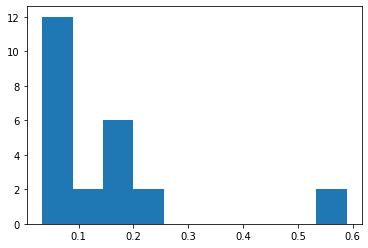

In [146]:
plt.hist(ls_influence_score)
plt.show()

1. arrays with all features (citations, h-index citations, references, authors, sensors, frames)
2. percentile rank by year of each feature
3. Influence Score

In [195]:
references_array = np.empty([len(retrieved_data), 15])
citations_array = np.empty([len(retrieved_data), 15])
citations_citations_array = np.empty([len(retrieved_data), 15])
author_array = np.empty([len(retrieved_data), 15])
citations_citations_sum_array = np.empty([len(retrieved_data), 15])
sensors_array = np.empty([len(retrieved_data), 15])
frames_array = np.empty([len(retrieved_data), 15])

references_array[:] = np.nan
citations_array[:] = np.nan
citations_citations_array[:] = np.nan
author_array[:] = np.nan
sensors_array[:] = np.nan
frames_array[:] = np.nan
citations_citations_sum_array[:] = np.nan

names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    names.append(o_paper['id'])
    try:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  int(len(list(o_paper['sensors'].split(','))))
    except:
        sensors_array[paper_idx, o_paper['paperInfo']['year']-2008:] =  float("NaN")
    try:
        if o_paper['frames'] != "-":
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = int(o_paper['frames'].replace(',', ''))
    except:
                frames_array[paper_idx, o_paper['paperInfo']['year']-2008:] = float("NaN")
    for index in range(14, 0, -1): #index = 16 = year 2022
        dist = 2008 + index - o_paper['paperInfo']['year']
        if dist < 0:
            break
        scorer = scoring(o_paper, 3, dist, dist)
        ls_author_scores = []
        for author_number, author in enumerate(o_paper['paperInfo']['authors']):
            single_author_score = scorer.citations_single_author_score(author_number)
            ls_author_scores.append(single_author_score)
        author_array[paper_idx, index] = np.mean(ls_author_scores)
        references_array[paper_idx, index] = scorer.reference_score()
        citations_array[paper_idx, index] = scorer.citations_h3() #todo: or just_citations()
        citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
        citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


100%|██████████| 185/185 [00:12<00:00, 15.10it/s]


In [196]:
#make list of tupels with (feature_name, array)
arrays_over_time = [('refs', references_array), ('cit', citations_array), ('h-cit', citations_citations_array), ('authors', author_array), ('sensors', sensors_array), ('frames', frames_array)]

In [197]:
def percentile_rank(np_array):
    """takes np_array and calculates percentile ranks by column (year)"""
    df_percentile_ranks = pd.DataFrame(np_array)
    return np.array(df_percentile_ranks.rank(pct=True, axis=0))

In [198]:
#calaculate all percentile ranks
nan_array = np.empty([len(retrieved_data), 15])
nan_array[:] = np.nan
percentile_array = [('influence_score', nan_array)]
for array in arrays_over_time:
    percentile_array.append((array[0], percentile_rank(array[1])))


In [199]:
percentile_array[2][1]

array([[       nan,        nan,        nan, ..., 1.        , 1.        ,
        1.        ],
       [       nan,        nan,        nan, ..., 0.99253731, 0.99375   ,
        0.99459459],
       [       nan,        nan,        nan, ..., 0.98134328, 0.984375  ,
        0.98648649],
       ...,
       [       nan,        nan,        nan, ..., 0.2761194 , 0.38125   ,
        0.45405405],
       [       nan,        nan,        nan, ...,        nan, 0.028125  ,
        0.08648649],
       [       nan,        nan,        nan, ...,        nan,        nan,
        0.03513514]])

In [200]:
# selected_features = ['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors', 'frames']
for dataset in range(percentile_array[1][1].shape[0]):
    print(dataset, percentile_array[1][1].shape[0])
    for year in range(percentile_array[1][1].shape[1]):
        if not np.isnan(percentile_array[3][1][dataset][year]):
            scores = pd.Series({percentile_array[1][0]: percentile_array[1][1][dataset][year], percentile_array[2][0]: percentile_array[2][1][dataset][year], percentile_array[3][0]: percentile_array[3][1][dataset][year], percentile_array[4][0]: percentile_array[4][1][dataset][year], percentile_array[5][0]: percentile_array[5][1][dataset][year], percentile_array[6][0]: percentile_array[6][1][dataset][year]})
            print(scores)
            percentile_array[0][1][dataset][year] = influence_score(scores, selected_features='all')
#

0 185
refs       0.25000
cit        1.00000
h-cit      0.25000
authors    0.06250
sensors    0.90625
frames         NaN
dtype: float64
refs       0.190476
cit        1.000000
h-cit      0.452381
authors    0.047619
sensors    0.904762
frames          NaN
dtype: float64
refs       0.18
cit        1.00
h-cit      0.78
authors    0.04
sensors    0.86
frames      NaN
dtype: float64
refs       0.180556
cit        1.000000
h-cit      0.916667
authors    0.027778
sensors    0.875000
frames          NaN
dtype: float64
refs       0.145833
cit        1.000000
h-cit      0.937500
authors    0.041667
sensors    0.895833
frames          NaN
dtype: float64
refs       0.144928
cit        1.000000
h-cit      0.985507
authors    0.253623
sensors    0.840580
frames          NaN
dtype: float64
refs       0.097222
cit        1.000000
h-cit      1.000000
authors    0.439815
sensors    0.782407
frames          NaN
dtype: float64
refs       0.074627
cit        1.000000
h-cit      1.000000
authors    0.645522

In [201]:
top_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).drop_duplicates().sort_values(14, axis=0, ascending=False).iloc[:5, :]
#drop_duplicates removes nuScenes because it is a duplicate of nuImages (although frames differ slightly. Leeds to very confusing plots)
top_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,NaN,NaN,NaN,NaN,1.0000,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,NaN,NaN,NaN,NaN,NaN,0.9375,0.952381,0.96,0.972222,0.979167,0.985507,0.990741,0.992537,0.993750,0.994595
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.976852,0.981343,0.984375,0.986486
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.944444,0.958333,0.971014,0.962963,0.970149,0.975000,0.978378
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916667,0.937500,0.956522,0.953704,0.962687,0.968750,0.972973


In [202]:
bottom_5 = pd.DataFrame(percentile_array[2][1]).dropna(thresh=4).sort_values(14, axis=0, ascending=True).iloc[:5, :]
bottom_5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009259,0.014925,0.078125,0.151351
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020833,0.014493,0.018519,0.044776,0.118750,0.224324
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027778,0.052239,0.125000,0.232432
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037037,0.059701,0.137500,0.243243
179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028986,0.046296,0.074627,0.159375,0.262162


In [203]:
top_and_bottom_5 = list(top_5.index)+list(bottom_5.index)
print(top_and_bottom_5)

[0, 1, 2, 4, 5, 118, 112, 109, 152, 179]


In [204]:
top_bottom_names = []
for ids in top_and_bottom_5:
    top_bottom_names.append(names[ids])
top_bottom_names

['KITTI',
 'Cars',
 'nuImages',
 'Synthia',
 'GTA5',
 'WZ-traffic',
 'TRoM',
 'MCity Data Collection',
 'HSD',
 'TAF-BW']

10 10


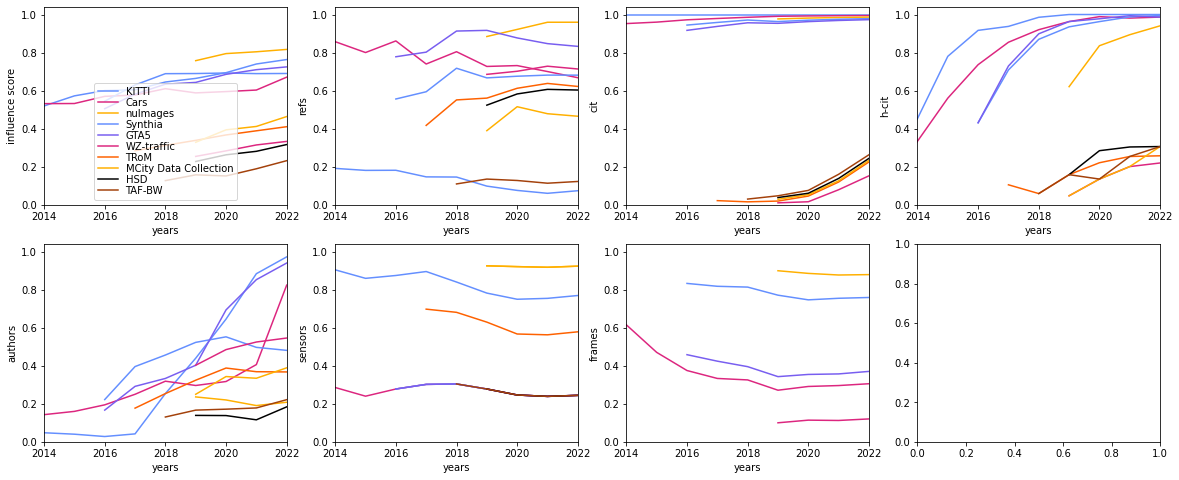

In [206]:
colors = ['#648fff', '#dc267f', '#ffb000', '#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#000000', '#A3410B']
print(len(colors), len(top_and_bottom_5))
fig, axs = plt.subplots(figsize=(20, 8), nrows=2, ncols=4)
#fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)
first = True
for ax, feature in zip(axs.flat, percentile_array):
    for i_row, row in enumerate(top_and_bottom_5):
        ax.plot([*range(2008, 2023)], feature[1][row], label=names[row], color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=feature[0].replace('_', ' '))
    if first:
        ax.legend(top_bottom_names, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False

plt.savefig('output/influence_scores.pdf')
plt.show()

In [164]:
#select top 5 and bottom 5 (older than?)


In [165]:
yr = 2022
array = np.empty([len(retrieved_data), 6])
array[:] = np.nan
names = []
for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
    scorer = scoring(o_paper, 200, yr, yr)
    reference = scorer.reference_score()
    citations_citations = scorer.citations_citations_score()
    citations = scorer.just_citations()
    ls_author_scores = []
    names.append(o_paper['id'])
    for author_number, author in enumerate(o_paper['paperInfo']['authors']):
        single_author_score = scorer.citations_single_author_score(author_number)
        ls_author_scores.append(single_author_score)
    author = np.mean(ls_author_scores)
    try:
        score = o_paper['altmetrics'][0]['score']
        total_readers = o_paper['altmetrics'][3]['total_readers']
    except:
        percentile = float("NaN")
        total_readers = float("NaN")

    array[paper_idx][:] = [citations, citations_citations, total_readers, score, reference, author]
array

100%|██████████| 185/185 [00:01<00:00, 94.36it/s] 


array([[5.330e+03, 1.510e+02, 2.001e+03, 1.225e+01, 1.300e+01, 3.300e+01],
       [1.946e+03, 1.070e+02,       nan, 3.000e+00, 3.600e+01, 2.175e+01],
       [1.818e+03, 6.900e+01,       nan, 3.000e+00, 6.900e+01, 8.400e+00],
       ...,
       [3.500e+01, 8.000e+00,       nan, 0.000e+00, 2.400e+01, 2.025e+01],
       [1.000e+00, 0.000e+00,       nan, 0.000e+00, 4.400e+01, 7.000e+00],
       [0.000e+00, 0.000e+00,       nan, 0.000e+00, 5.300e+01, 6.400e+00]])

In [166]:
spider_web = pd.DataFrame(array, columns=['citations', 'citations_citations', 'total_readers', 'score', 'reference', 'author']).set_axis(names)
spider_web['Altmetric'] = spider_web.score.rank(pct = True)
spider_web['cit'] = spider_web.citations.rank(pct = True)
spider_web['h-cit'] = spider_web.citations_citations.rank(pct = True)
spider_web['readers'] = spider_web.total_readers.rank(pct = True)
spider_web['refs'] = spider_web.reference.rank(pct = True)
spider_web['authors'] = spider_web.author.rank(pct = True)
spider_web

,citations,citations_citations,total_readers,score,reference,author,Altmetric,cit,h-cit,readers,refs,authors
KITTI,5330.0,151.0,2001.0,12.25,13.0,33.000000,0.983784,1.000000,1.000000,1.000000,0.072973,0.972973
Cars,1946.0,107.0,NaN,3.00,36.0,21.750000,0.786486,0.994595,0.986486,NaN,0.662162,0.778378
nuImages,1818.0,69.0,NaN,3.00,69.0,8.400000,0.786486,0.986486,0.940541,NaN,0.959459,0.197297
nuScenes,1818.0,71.0,NaN,3.00,69.0,8.400000,0.786486,0.986486,0.945946,NaN,0.959459,0.197297
Synthia,1542.0,108.0,NaN,9.00,37.0,13.000000,0.940541,0.978378,0.994595,NaN,0.675676,0.440541
...,...,...,...,...,...,...,...,...,...,...,...,...
TITAN,53.0,10.0,NaN,0.00,52.0,12.666667,0.308108,0.524324,0.502703,NaN,0.864865,0.427027
USyd Campus,8.0,2.0,9.0,2.00,20.0,16.571429,0.708108,0.210811,0.181081,0.038462,0.186486,0.578378
UTBM EU LTD,35.0,8.0,NaN,0.00,24.0,20.250000,0.308108,0.454054,0.432432,NaN,0.318919,0.721622
VLMV - Vehicle Lane Merge Visual Benchmark,1.0,0.0,NaN,0.00,44.0,7.000000,0.308108,0.086486,0.056757,NaN,0.789189,0.132432


In [167]:
#todo: 5best - 5 worst by impact time development graphy
#table for all new ones this year


0
0
0
1
1
1
2
2
2
3
3
3


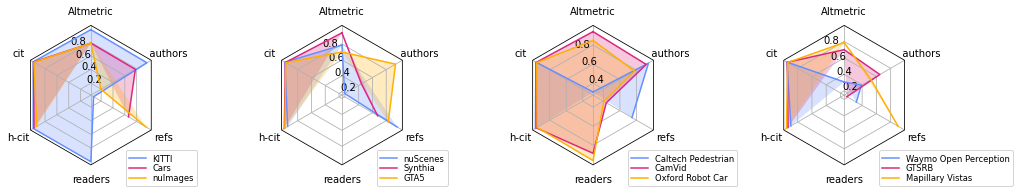

In [168]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

N = 6
theta = radar_factory(N, frame='polygon')
values = [[], [], [], []]
web_names = [[], [], [], []]
data = []
k = 0
for i in range(12):
    row = (spider_web.iloc[i][-6:])
    if i%3 == 0 and i != 0:
        k += 1
    print(k)
    values[k].append( list(row))
    web_names[k].append(row.name)

dimension_names = []
for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('author', '   author'))
data = [dimension_names, ('', web_names[0], values[0]), ('', web_names[1], values[1]), ('', web_names[2], values[2]), ('', web_names[3], values[3])]

#print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.8, hspace=0.0, top=0.95, bottom=0.05)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.75, -0.15),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

#fig.text(0.5, 0.7, 'Influence of Successful Papers',
#         horizontalalignment='center', color='black', weight='bold',
#         size='large')
plt.savefig('output/spider_web_at.pdf', bbox_inches='tight')
plt.show()

[['Altmetric', 'cit', 'h-cit', 'readers', 'refs', 'authors'], ('', ['Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE'], [[0.3081081081081081, 0.6648648648648648, 0.5243243243243243, nan, 0.6621621621621622, 0.43243243243243246], [0.3081081081081081, 0.5378378378378378, 0.5243243243243243, nan, 0.9972972972972973, 0.8891891891891892], [0.3081081081081081, 0.5027027027027027, 0.35945945945945945, nan, 0.845945945945946, 0.5351351351351351]]), ('', ['MAVD Multimodal Audio-Visual Detection', 'MOTSynth', 'RoadAnomaly21'], [[0.3081081081081081, 0.43243243243243246, 0.3054054054054054, nan, 0.727027027027027, 0.21351351351351353], [0.3081081081081081, 0.4081081081081081, 0.21891891891891893, nan, 0.981081081081081, 0.518918918918919], [0.6702702702702703, 0.3945945945945946, 0.35945945945945945, nan, 0.7027027027027027, 0.7594594594594595]])]


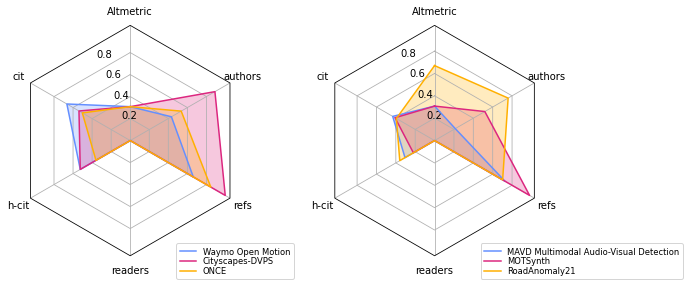

In [169]:
import math
N = 6
theta = radar_factory(N, frame='polygon')
'''values = [[], [], [], []]
web_names = [[], [], [], []]
for i in range(2):
    row = (spider_web.iloc[i][-6:])
    values[0].append(list(row))
    web_names[0].append(row.name)'''

values_21 = [[], []]
web_names_21 = [[], []]
for index, i in enumerate(['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'MAVD Multimodal Audio-Visual Detection', 'MOTSynth', 'RoadAnomaly21']):
    # top 6 ['Waymo Open Motion', 'SemKITTI-DVPS', 'Cityscapes-DVPS', 'ONCE', 'RoadAnomaly21', 'MOTSynth', 'RoadAnomaly21'] #'SemKITTI-DVPS', 'Cityscapes-DVPS' are the same
    if i == 'SemKITTI-DVPS':
        continue
    row = (spider_web.loc[i][-6:])
    if index <= 3:
        values_21[0].append(list(row))
        web_names_21[0].append(row.name)
    else:
        values_21[1].append(list(row))
        web_names_21[1].append(row.name)
dimension_names = []

for name in enumerate(list(spider_web.columns[-6:])):
    #print(name[1])
    dimension_names.append(name[1].replace('_', '\n'))
data = [dimension_names, ('', web_names_21[0], values_21[0]), ('', web_names_21[1], values_21[1])]

print(data)
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(10, 4), nrows=1, ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.2, hspace=0.10, top=0.9, bottom=0.1)

# Plot the four cases from the example data on separate axes
colors = ['#648fff', '#dc267f', '#ffb000'] #['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000']
for ax, (title, label, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    '''ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.4),
                 horizontalalignment='center', verticalalignment='center')'''
    a = 0
    for d, color in zip(case_data, colors):
        for index, score in enumerate(d):
            if math.isnan(score):
                d[index] = 0
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
        a += 1
    ax.set_varlabels(spoke_labels)
    ax.legend(label, loc=(0.7, -0.1),
                          labelspacing=0.1, fontsize='small')

# add legend relative to top-left plot
#labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
#legend = axs[0, 0].legend(labels, loc=(0.9, .95),
#                          labelspacing=0.1, fontsize='small')

plt.savefig('output/spider_web_at_best_of_21.pdf', bbox_inches='tight')
plt.show()

In [170]:
same_start_year = False
if same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])

    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(16):
            yr = o_paper['paperInfo']['year'] + index
            if yr > 2022:
                break
            scorer = scoring(o_paper, 50, index, index)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()

In [171]:
if not same_start_year:
    references_array = np.empty([len(retrieved_data), 15])
    citations_array = np.empty([len(retrieved_data), 15])
    citations_citations_array = np.empty([len(retrieved_data), 15])
    author_array = np.empty([len(retrieved_data), 15])
    citations_citations_sum_array = np.empty([len(retrieved_data), 15])
    references_array[:] = np.nan
    citations_array[:] = np.nan
    citations_citations_array[:] = np.nan
    author_array[:] = np.nan
    citations_citations_sum_array[:] = np.nan
    names = []
    for paper_idx, o_paper in enumerate(tqdm(retrieved_data)):
        names.append(o_paper['id'])
        for index in range(14, 0, -1): #index = 16 = year 2022
            dist = 2008+ index-o_paper['paperInfo']['year']
            if dist < 0:
                break
            scorer = scoring(o_paper, 50, dist, dist)

            ls_author_scores = []
            for author_number, author in enumerate(o_paper['paperInfo']['authors']):
                single_author_score = scorer.citations_single_author_score(author_number)
                ls_author_scores.append(single_author_score)
            author_array[paper_idx, index] = np.mean(ls_author_scores)
            references_array[paper_idx, index] = scorer.reference_score()
            citations_array[paper_idx, index] = scorer.just_citations()
            citations_citations_array[paper_idx, index] = scorer.citations_citations_score()
            citations_citations_sum_array[paper_idx, index] = scorer.citations_citations_sum()


100%|██████████| 185/185 [00:08<00:00, 22.55it/s]


In [172]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)
for i in range(15):
    author_df.iloc[:, i] = author_df.iloc[:, i].rank(pct = True)
    references_df.iloc[:, i] = references_df.iloc[:, i].rank(pct = True)
    citations_df.iloc[:, i] = citations_df.iloc[:, i].rank(pct = True)
    citations_citations_df.iloc[:, i] = citations_citations_df.iloc[:, i].rank(pct = True)
author_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
KITTI,NaN,NaN,NaN,NaN,NaN,0.0625,0.047619,0.04,0.027778,0.041667,0.217391,0.398148,0.537313,0.843750,0.972973
Cars,NaN,NaN,NaN,NaN,NaN,0.1875,0.142857,0.16,0.194444,0.229167,0.289855,0.268519,0.257463,0.350000,0.778378
nuImages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254630,0.201493,0.178125,0.197297
nuScenes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254630,0.201493,0.178125,0.197297
Synthia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263889,0.354167,0.420290,0.472222,0.485075,0.459375,0.440541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TITAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.399254,0.400000,0.427027
USyd Campus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.619403,0.581250,0.578378
UTBM EU LTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.643519,0.720149,0.743750,0.721622
VLMV - Vehicle Lane Merge Visual Benchmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093750,0.132432


In [173]:
percentile_scores = {"authors": author_df, "references": references_df, "citations": citations_df, "citations_citations": citations_citations_df}

In [174]:
def relevance_score(scores, alpha=0.25, beta=0.25, gamma=0.25, theta=0.25, relative_c2=False): #Todo sum of weights = 1
    result = scores['references']*alpha + scores['authors']*beta + scores['citations']*gamma + scores['citations_citations']*theta
    if relative_c2:
        result = scores['citations_citations']/scores['citations']
    return result

In [175]:
relevance_scores = relevance_score(percentile_scores).round(3)
relevance_scores.columns = [*range(2008, 2023)]


In [176]:
relevance_scores = relevance_scores[pd.notna(relevance_scores[2019])]
relevance_scores = relevance_scores.sort_values([2022], ascending=[False])
relevance_scores.to_csv('output/infSco_equal_weigths.csv', header=[*range(2008, 2023)])

In [177]:
relevance_scores.duplicated(subset=[2022])

GTA5                   False
Caltech Pedestrian     False
Semantic KITTI         False
CULane                 False
LISA Traffic Sign      False
                       ...  
Unsupervised Llamas     True
BLVD                   False
Boxy                   False
Comma2k19              False
TAF-BW                 False
Length: 108, dtype: bool

In [178]:
relevance_scores = relevance_score(percentile_scores, alpha=0, beta=0, gamma=0.5, theta=0.5)

In [179]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','nuImages', 'Synthia', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

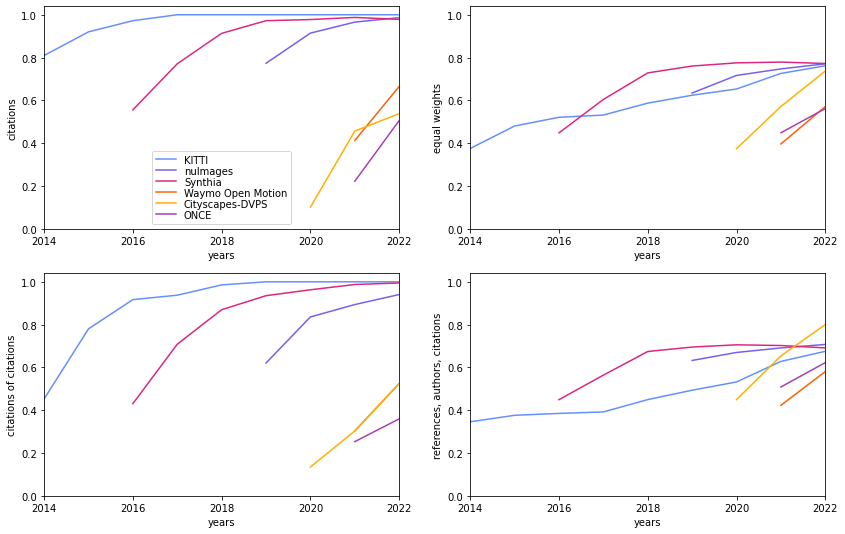

In [180]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores.pdf')
plt.show()

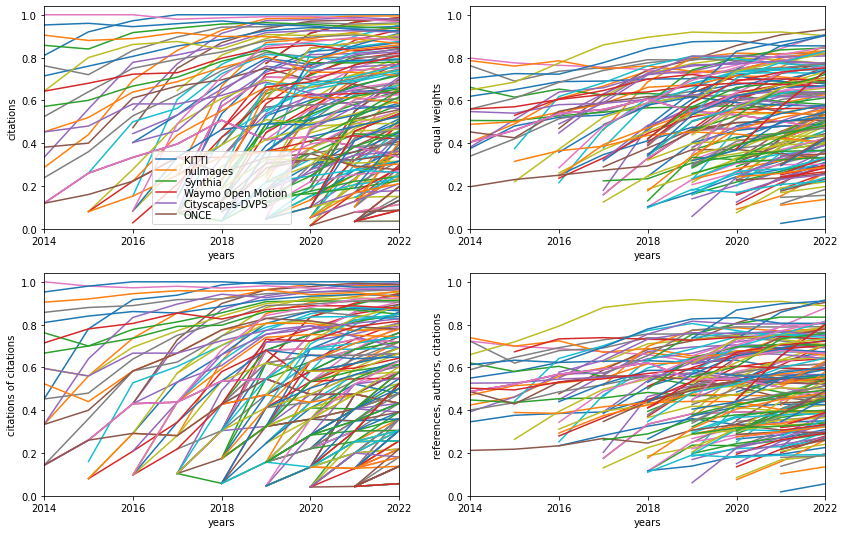

In [181]:
ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.loc[row])
        ax.plot([*range(2008, 2023)], relevance_scores.iloc[i_row], label=relevance_scores.iloc[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [182]:

ws = [('citations', [0, 0, 1, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('citations of citations', [0, 0, 0, 1]),  ('references, authors, citations', [0.33, 0.33, 0.33, 0])]
'''w = ws[0]
relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
for i_row, row in enumerate(datasets):
    plt.plot(relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
plt.legend(loc='best')
plt.show()'''
fig, axs = plt.subplots(figsize=(14, 8), nrows=2, ncols=2)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
        first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

KeyboardInterrupt: 

In [ ]:
ws = [('equal weights', [0.25, 0.25, 0.25, 0.25])]
ax = plt.subplot()
#ax.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.1)

first = True
for (scenario_name, w) in ws:
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(list(relevance_scores.index.values)):
        #print(relevance_scores.iloc[i_row])
        for i, score in enumerate(relevance_scores.iloc[i_row]):
            if score is not None:
                ax.scatter((2008+i), score, label=relevance_scores.iloc[i_row], alpha=0.3)
    ax.set(xlim=(2008, 2023), ylim=(0, 1.04), xticks=[*range(2008, 2024, 2)], xlabel='years', ylabel=scenario_name)
    #if first:
    #    ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='medium')
    #    first = False
plt.savefig('output/influence_scores_3.pdf')
plt.show()

In [ ]:
ws = [('citations', [0, 0, 1, 0]), ('h-index of citations', [0, 0, 0, 1]), ('references', [1, 0, 0, 0]), ('authors', [0, 1, 0, 0]), ('equal weights', [0.25, 0.25, 0.25, 0.25]), ('early post release', [0.5, 0, 0.5, 0])]
fig, axs = plt.subplots(figsize=(20, 8), nrows=2, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.8, bottom=0.2)

first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3])
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2012, 2022), ylim=(0, 1.04), xticks=[*range(2012, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='lower center', labelspacing=0.1, fontsize='small')
        first = False
plt.savefig('output/influence_scores2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#E7581E']
ws = [('citations', [0, 0, 1, 0]), ('citations of citations', [0, 0, 0, 1])]
fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=3)
fig.subplots_adjust(wspace=0.2, hspace=0, top=0.8, bottom=0.2)
datasets = ['KITTI', 'Cars Dataset', 'CamVid', 'DIPLECS Autonomous Driving Datasets', 'Illumination Changes in a day', 'AMUSE']
first = True
for ax, (scenario_name, w) in zip(axs.flat, ws):
    relevance_scores = relevance_score(percentile_scores, alpha=w[0], beta=w[1], gamma=w[2], theta=w[3], relative_c2=False)
    for i_row, row in enumerate(datasets):
        ax.plot([*range(2008, 2023)], relevance_scores.loc[row], label=relevance_scores.loc[row].name, color=colors[i_row])
    ax.set(xlim=(2014, 2022), ylim=(0, 1.04), xticks=[*range(2014, 2023, 2)], xlabel='years', ylabel=scenario_name)
    if first:
        ax.legend(datasets, loc='best', labelspacing=0.1, fontsize='small')
        first = False
#plt.savefig('output/influence_scores2.pdf')
plt.show()

In [ ]:
colors=['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000', '#A740AE']
datasets = ['KITTI','Synthia', 'nuScenes', 'Waymo Open Motion', 'Cityscapes-DVPS', 'ONCE']
interest = relevance_scores.loc[datasets]

In [ ]:
author_df = pd.DataFrame(author_array).set_axis(names)
references_df = pd.DataFrame(references_array).set_axis(names)
citations_df = pd.DataFrame(citations_array).set_axis(names)
citations_citations_df = pd.DataFrame(citations_citations_array).set_axis(names)
citations_citations_sum_df = pd.DataFrame(citations_citations_sum_array).set_axis(names)

In [ ]:
df = citations_citations_sum_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_sum_df.iloc[:144][14]#/citations_df.iloc[:144][14]).rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14] #.rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('(citations)')
plt.xlim(0, 1000)
plt.ylabel('(citations of citations)')
plt.savefig('output/citations_of_citations_per_citation.pdf')
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value

In [ ]:
x = pd.DataFrame(df.citation_rank)
mod = sm.OLS(df.citations_citations_rank, x.assign(intercept=1))
res = mod.fit()
print(res.summary())

In [ ]:
score  = (df.citations_citations_rank - res.fittedvalues).rank(pct=True)

In [ ]:
plt.scatter(df.citation_rank, list(score), alpha=1, s=4)
plt.xlim(0, 100)
plt.show()

In [ ]:
res.params

In [ ]:
score

In [ ]:
df = citations_citations_df.iloc[:144]
df['citations_citations_rank'] = citations_citations_df.iloc[:144][14].rank(pct = True)
df['citation_rank'] = citations_df.iloc[:144][14].rank(pct = True)
plt.scatter(df.citation_rank, df.citations_citations_rank, color='#648fff')
plt.xlabel('rank(citations)')
plt.ylabel('rank(citations of citations h)')
plt.savefig('output/citations_of_citations_per_citation.pdf')
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr(df.citation_rank, df.citations_citations_rank)
#correlation coeff, p-value